# MOVIE_DATA_ANALYSIS🎥🎬🎞️🍿

## 과제 🔥🔥🔥
### 배우/감독 네트워크 분석 및 성공 패턴 발견

#### 주요 배우와 감독들의 협업 관계를 네트워크로 시각화하고, 성공적인 콜라보레이션 패턴을 발견하여 캐스팅 전략에 대한 인사이트를 도출하세요.

In [1]:
import pandas as pd
import requests
import os
import time

# Load the TMDB API key from a system environment variable.
# Please ensure you have set the 'TMDB_API_KEY' environment variable.
api_key = os.getenv('TMDB_API_KEY')
base_url = 'https://api.themoviedb.org/3'
# The user's provided CSV file name
file_name = 'tmdb_kr_theatrical_2005_2025.csv'
# The name for the new output CSV file
output_file_name = 'tmdb_with_credits.csv'

class TokenBucket:
    """
    Implements a Token Bucket algorithm for rate limiting.
    This helps to make API calls as fast as possible without exceeding the limit.
    """
    def __init__(self, capacity, fill_rate):
        """
        Initializes the Token Bucket.
        Args:
            capacity (int): The maximum number of tokens the bucket can hold.
            fill_rate (float): The rate at which tokens are added to the bucket (tokens per second).
        """
        self.capacity = float(capacity)
        self.fill_rate = float(fill_rate)
        self.tokens = float(capacity)
        self.last_check_time = time.time()

    def get_token(self):
        """
        Requests a token. Waits if no tokens are available.
        """
        current_time = time.time()
        time_elapsed = current_time - self.last_check_time
        
        # Add new tokens to the bucket based on time elapsed
        self.tokens = min(self.capacity, self.tokens + time_elapsed * self.fill_rate)
        self.last_check_time = current_time
        
        # If there are not enough tokens, wait until one is available
        if self.tokens < 1.0:
            time_to_wait = 1.0 / self.fill_rate - time_elapsed
            time.sleep(time_to_wait)
            self.tokens = self.capacity
            self.last_check_time = time.time()
        
        self.tokens -= 1.0

def fetch_credits(movie_id, api_key, token_bucket):
    """
    Fetches the main actors and the director for a specific movie from the TMDB API.
    Uses a TokenBucket to manage the rate of API calls.

    Args:
        movie_id (int): The ID of the movie.
        api_key (str): Your TMDB API key.
        token_bucket (TokenBucket): The TokenBucket instance to get tokens from.

    Returns:
        tuple: A tuple containing a list of actor names (top 5) and the director's name.
    """
    # Wait for a token from the bucket before making the API call
    token_bucket.get_token()

    try:
        url = f"{base_url}/movie/{movie_id}/credits?api_key={api_key}"
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes
        data = response.json()

        # Get the top 5 actors
        actors = [cast['name'] for cast in data.get('cast', [])[:5]]
        # Find the director
        director = next((crew['name'] for crew in data.get('crew', []) if crew['job'] == 'Director'), None)

        return actors, director
    except requests.exceptions.RequestException as e:
        print(f"Error fetching credits for movie ID {movie_id}: {e}")
        return [], None
    except KeyError as e:
        print(f"KeyError: Missing data in API response for movie ID {movie_id}. Error: {e}")
        return [], None

def process_and_save_data(input_file, output_file, api_key):
    """
    Reads movie data, fetches credits, and saves the updated data to a new CSV file.
    
    Args:
        input_file (str): The name of the input CSV file.
        output_file (str): The name of the output CSV file.
        api_key (str): Your TMDB API key.
    """
    if not api_key:
        print("TMDB API key not found. Please set the 'TMDB_API_KEY' environment variable.")
        return

    try:
        df = pd.read_csv(input_file)
    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
        return

    # Add new columns to the DataFrame
    df['director'] = None
    df['actors'] = None

    # Initialize the Token Bucket with TMDB's rate limit: 40 calls per 10 seconds.
    # This translates to a fill rate of 4 tokens per second.
    token_bucket = TokenBucket(capacity=40, fill_rate=4.0)

    print(f"Processing {len(df)} movies...")
    for index, row in df.iterrows():
        movie_id = row['movie_id']
        
        # Call the function to get credits, passing the token bucket
        actors, director = fetch_credits(movie_id, api_key, token_bucket)
        
        # Update the DataFrame with the new information
        df.loc[index, 'director'] = director
        # Store actors as a string for easy CSV saving
        df.loc[index, 'actors'] = ', '.join(actors)
        
        # Print progress
        if (index + 1) % 50 == 0:
            print(f"Processed {index + 1} movies.")
    
    # Save the updated DataFrame to a new CSV file
    try:
        df.to_csv(output_file, index=False)
        print(f"\nSuccessfully saved the updated data to '{output_file}'.")
    except Exception as e:
        print(f"Error saving the file: {e}")

# Run the main process
if __name__ == '__main__':
    process_and_save_data(file_name, output_file_name, api_key)


Processing 4662 movies...
Processed 50 movies.
Processed 100 movies.
Processed 150 movies.
Processed 200 movies.
Processed 250 movies.
Processed 300 movies.
Processed 350 movies.
Processed 400 movies.
Processed 450 movies.
Processed 500 movies.
Processed 550 movies.
Processed 600 movies.
Processed 650 movies.
Processed 700 movies.
Processed 750 movies.
Processed 800 movies.
Processed 850 movies.
Processed 900 movies.
Processed 950 movies.
Processed 1000 movies.
Processed 1050 movies.
Processed 1100 movies.
Processed 1150 movies.
Processed 1200 movies.
Processed 1250 movies.
Processed 1300 movies.
Processed 1350 movies.
Processed 1400 movies.
Processed 1450 movies.
Processed 1500 movies.
Processed 1550 movies.
Processed 1600 movies.
Processed 1650 movies.
Processed 1700 movies.
Processed 1750 movies.
Processed 1800 movies.
Processed 1850 movies.
Processed 1900 movies.
Processed 1950 movies.
Processed 2000 movies.
Processed 2050 movies.
Processed 2100 movies.
Processed 2150 movies.
Proce

In [3]:
# pandas 라이브러리를 pd라는 별명으로 불러옵니다.
# 데이터프레임(표 형태의 데이터)을 다루는 데 필수적인 도구입니다.
import pandas as pd

try:
    # 'tmdb_with_credits.csv' 파일을 읽어서 데이터프레임(df)으로 만듭니다.
    # 인코딩 오류가 발생할 수 있어 'utf-8' 인코딩을 명시해줍니다.
    df = pd.read_csv('tmdb_with_credits.csv', encoding='utf-8')
    print("✅ 'tmdb_with_credits.csv' 파일을 성공적으로 불러왔습니다.\n")

    # --- 데이터프레임 확인 단계 ---
    
    # 1. 데이터프레임의 상위 5개 행을 출력합니다.
    # 이를 통해 데이터가 올바르게 로드되었는지 빠르게 확인할 수 있습니다.
    print("--- 데이터프레임 상위 5개 행 (df.head()) ---")
    print(df.head())
    print("\n" + "-"*50 + "\n")

    # 2. 데이터프레임의 요약 정보를 출력합니다.
    # 각 열의 데이터 타입과 누락된 값(non-null)의 개수를 알려줍니다.
    # 'cast'와 'crew' 열이 'object' 타입으로 잘 인식되었는지 확인하는 것이 중요합니다.
    print("--- 데이터프레임 요약 정보 (df.info()) ---")
    df.info()
    print("\n" + "-"*50 + "\n")

    # 3. 데이터프레임의 기술 통계 정보를 출력합니다.
    # 주로 숫자형 데이터에 대한 통계 정보(평균, 표준편차 등)를 보여줍니다.
    print("--- 데이터프레임 통계 정보 (df.describe()) ---")
    print(df.describe())
    print("\n")

except FileNotFoundError:
    # 파일이 없는 경우 발생하는 오류를 처리합니다.
    print("❌ 오류: 'tmdb_with_credits.csv' 파일을 찾을 수 없습니다.")
    print("파일이 이 스크립트와 같은 폴더에 있는지 확인하거나, 파일 경로를 다시 지정해주세요.")
except Exception as e:
    # 기타 예외 상황을 처리합니다.
    print(f"❌ 오류가 발생했습니다: {e}")


✅ 'tmdb_with_credits.csv' 파일을 성공적으로 불러왔습니다.

--- 데이터프레임 상위 5개 행 (df.head()) ---
   movie_id    title original_title original_language release_date  runtime  \
0       670     올드보이           올드보이                ko   2003-11-21      120   
1      1255       괴물             괴물                ko   2006-07-27      119   
2      1963        활              활                ko   2005-05-12       88   
3      2015       밀양             밀양                ko   2007-05-23      142   
4      4550  친절한 금자씨        친절한 금자씨                ko   2005-07-29      112   

     budget   revenue  vote_average  vote_count  popularity  \
0   3000000  17500000         8.252        9150     11.6819   
1  11000000  88489643         6.980        2931      4.4383   
2    950000   2032404         6.921         208      1.2098   
3   2900000  11581469         7.193         215      1.6151   
4         0  23803308         7.500        1752      3.3480   

                         genres  \
0  ['드라마', '스릴러', '미스터리', '액션']

'networkx'가 이미 설치되어 있습니다.
'matplotlib'가 이미 설치되어 있습니다.
'pandas'가 이미 설치되어 있습니다.
Matplotlib 한글 폰트 설정이 완료되었습니다.
CSV 파일을 성공적으로 불러왔습니다.
데이터프레임의 'actors' 열 변환이 완료되었습니다.
흥행작 수익 기준 (상위 10%): $50,924,453.40
총 31개의 흥행작을 찾았습니다.

상위 10개 협업 조합:
  - Bong Joon Ho & SongKang-ho: 3회 협업
  - Choi Dong-hoon & LeeJung-jae: 2회 협업
  - Choi Dong-hoon & JunJi-hyun: 2회 협업
  - Ryoo Seung-wan & HwangJung-min: 2회 협업
  - Ryoo Seung-wan & OhDal-su: 2회 협업
  - Ryoo Seung-wan & JangYoon-ju: 2회 협업
  - Kim Yong-hwa & HaJung-woo: 2회 협업
  - Kim Yong-hwa & JuJi-hoon: 2회 협업
  - Kim Yong-hwa & KimHyang-gi: 2회 협업
  - Lee Sang-yong & DonLee: 2회 협업


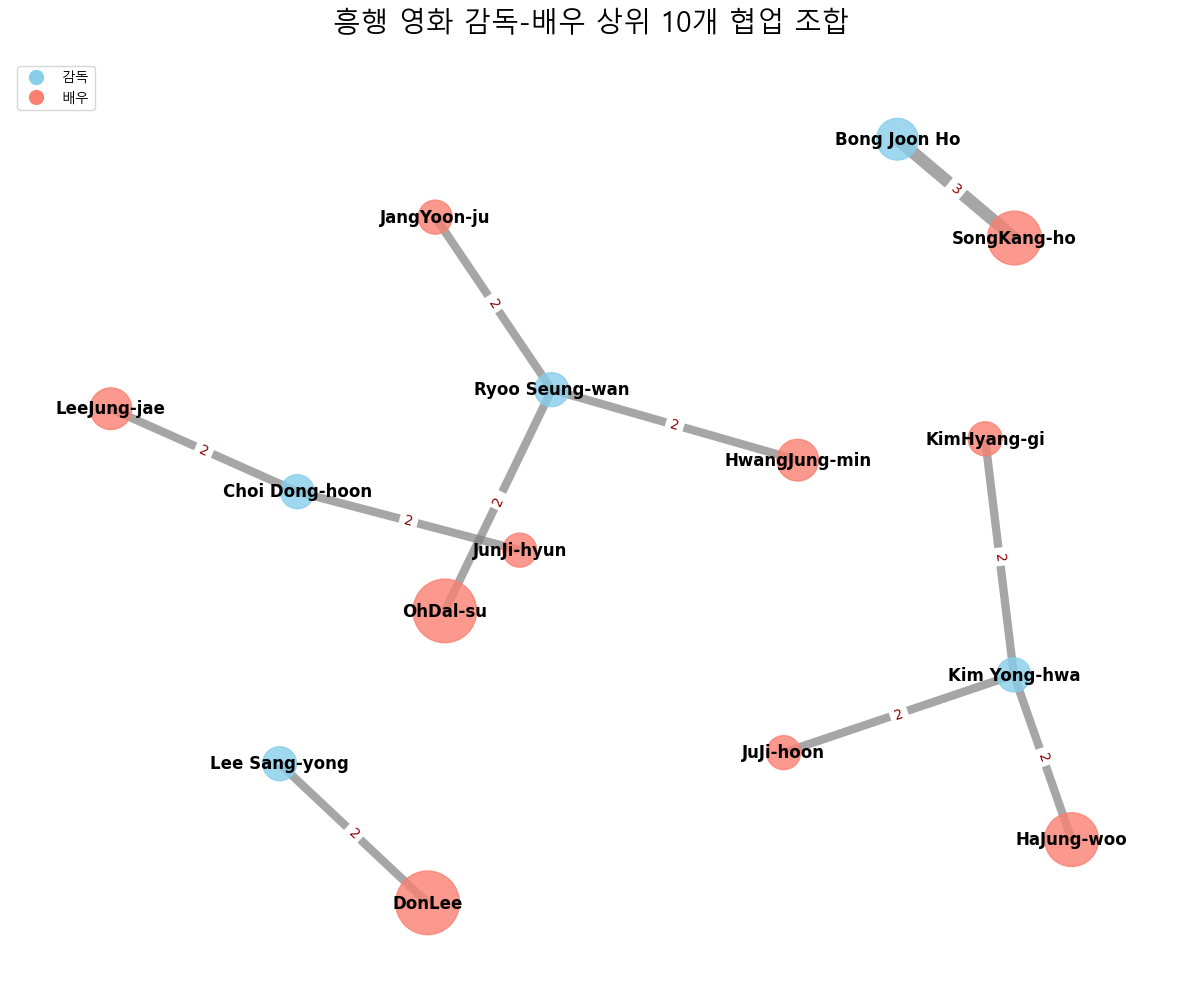


상위 10개 흥행 조합 네트워크 시각화가 완료되었습니다.
노드의 크기는 해당 인물이 흥행작에 참여한 총 횟수를 나타냅니다.
엣지(선)의 두께와 숫자는 해당 감독-배우 조합의 협업 횟수를 나타냅니다.


In [11]:
import subprocess
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from collections import Counter
import re
import matplotlib.lines as mlines

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore', category=UserWarning)

# 필요한 라이브러리가 설치되어 있는지 확인하고, 없으면 설치합니다.
def install_and_import(package):
    """지정된 패키지를 설치하고 임포트합니다."""
    try:
        __import__(package)
        print(f"'{package}'가 이미 설치되어 있습니다.")
    except ImportError:
        print(f"'{package}'가 설치되어 있지 않습니다. 설치를 시작합니다...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"'{package}' 설치 완료!")
        __import__(package)

# 네트워크 시각화에 필요한 라이브러리들을 설치합니다.
install_and_import("networkx")
install_and_import("matplotlib")
install_and_import("pandas")

# 사용자가 요청한 폰트 및 설정 적용
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
print("Matplotlib 한글 폰트 설정이 완료되었습니다.")

# 파일 경로를 여기에 입력하세요.
file_path = 'tmdb_with_credits.csv'

try:
    df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
    print("CSV 파일을 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    exit()

# --- 배우 이름 문자열을 안전하게 파싱하는 함수 ---
def parse_actors(actor_string):
    """
    다양한 형식의 배우 이름 문자열을 파싱하여 리스트로 반환합니다.
    예: "['배우1', '배우2']", "배우1, 배우2"
    """
    if pd.isna(actor_string) or not actor_string:
        return []
    
    # 괄호와 따옴표를 제거합니다.
    clean_string = re.sub(r"[\[\]'\" ]", "", str(actor_string))
    
    # 쉼표를 기준으로 이름을 분리하고, 공백 제거 후 빈 문자열을 필터링합니다.
    actors_list = [name.strip() for name in clean_string.split(',') if name.strip()]
    return actors_list

df['actors'] = df['actors'].apply(parse_actors)
print("데이터프레임의 'actors' 열 변환이 완료되었습니다.")

# --- 흥행작 기준 정의 (revenue 상위 10%) ---
valid_revenue_df = df[(df['revenue'].notna()) & (df['revenue'] > 0)].copy()

if valid_revenue_df.empty:
    print("유효한 수익 데이터가 있는 영화가 없습니다. 분석을 진행할 수 없습니다.")
    exit()

revenue_threshold = valid_revenue_df['revenue'].quantile(0.90)
hit_movies_df = valid_revenue_df[valid_revenue_df['revenue'] >= revenue_threshold].copy()
print(f"흥행작 수익 기준 (상위 10%): ${revenue_threshold:,.2f}")
print(f"총 {len(hit_movies_df)}개의 흥행작을 찾았습니다.")

if hit_movies_df.empty:
    print("90번째 백분위수 수익을 기준으로 흥행작을 찾을 수 없습니다. 기준이 너무 높을 수 있습니다.")
    exit()

# --- 감독-배우 협업 횟수를 세어 상위 10개 조합 찾기 ---
collaboration_counts = Counter()
for _, row in hit_movies_df.iterrows():
    director = row['director']
    actors_list = row['actors']
    
    if pd.isna(director):
        continue

    for actor in actors_list:
        if not actor:
            continue
        collaboration_counts[(director, actor)] += 1

# 상위 10개 조합 추출
top_10_collaborations = collaboration_counts.most_common(10)
print(f"\n상위 10개 협업 조합:")
for (director, actor), count in top_10_collaborations:
    print(f"  - {director} & {actor}: {count}회 협업")

if not top_10_collaborations:
    print("협업 조합을 찾을 수 없습니다. 프로그램을 종료합니다.")
    exit()

# --- 상위 10개 협업만을 위한 네트워크 그래프 생성 ---
G_top = nx.Graph()

# 상위 10개 조합에 속한 모든 인물을 수집
personnel_in_top_10 = set()
for (director, actor), _ in top_10_collaborations:
    personnel_in_top_10.add(director)
    personnel_in_top_10.add(actor)

# 노드와 엣지 생성
for (director, actor), count in top_10_collaborations:
    # 감독 노드와 배우 노드 추가
    G_top.add_node(director, type='director')
    G_top.add_node(actor, type='actor')
    
    # 엣지 추가 (가중치는 협업 횟수)
    G_top.add_edge(director, actor, weight=count)

# 상위 10개 인물의 흥행작 참여 횟수 카운트
personnel_participation_counts = Counter()
for person in personnel_in_top_10:
    for _, row in hit_movies_df.iterrows():
        director = row['director']
        actors_list = row['actors']
        if pd.notna(director) and director == person:
            personnel_participation_counts[person] += 1
        elif person in actors_list:
            personnel_participation_counts[person] += 1

# 노드 크기를 흥행작 참여 횟수에 비례하여 설정
node_sizes = [personnel_participation_counts.get(node, 0) * 300 for node in G_top.nodes()]

# 노드 색상을 감독/배우에 따라 설정
node_colors = ['skyblue' if G_top.nodes[n]['type'] == 'director' else 'salmon' for n in G_top.nodes()]

# 엣지 두께를 협업 횟수에 비례하여 설정
edge_weights = [G_top[u][v]['weight'] for u, v in G_top.edges()]
edge_widths = [weight * 3 for weight in edge_weights]

# 그래프 레이아웃 설정
pos = nx.spring_layout(G_top, k=1.0, iterations=50, seed=42)

plt.figure(figsize=(15, 12))
plt.title("흥행 영화 감독-배우 상위 10개 협업 조합", fontsize=20, pad=20)

# 노드, 엣지, 라벨 그리기
nx.draw_networkx_nodes(G_top, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G_top, pos, width=edge_widths, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(G_top, pos, font_size=12, font_color='black', font_weight='bold')

# 엣지 라벨(협업 횟수) 추가
edge_labels = nx.get_edge_attributes(G_top, 'weight')
nx.draw_networkx_edge_labels(G_top, pos, edge_labels=edge_labels, font_size=10, font_color='darkred')

# 범례 추가
legend_elements = [
    mlines.Line2D([], [], color='skyblue', marker='o', linestyle='None',
                  markersize=10, label='감독'),
    mlines.Line2D([], [], color='salmon', marker='o', linestyle='None',
                  markersize=10, label='배우')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.axis('off')
plt.show()

print("\n상위 10개 흥행 조합 네트워크 시각화가 완료되었습니다.")
print("노드의 크기는 해당 인물이 흥행작에 참여한 총 횟수를 나타냅니다.")
print("엣지(선)의 두께와 숫자는 해당 감독-배우 조합의 협업 횟수를 나타냅니다.")



Matplotlib 한글 폰트 설정이 완료되었습니다.
CSV 파일을 성공적으로 불러왔습니다.
데이터프레임의 'actors' 열 변환이 완료되었습니다.

'profit' (순수익) 열이 생성되었습니다.
흥행작 순수익 기준 (상위 10%): $45,488,581.60
총 29개의 흥행작을 찾았습니다.

상위 10개 협업 조합:
  - Bong Joon Ho & SongKang-ho: 3회 협업
  - Choi Dong-hoon & LeeJung-jae: 2회 협업
  - Choi Dong-hoon & JunJi-hyun: 2회 협업
  - Ryoo Seung-wan & HwangJung-min: 2회 협업
  - Ryoo Seung-wan & OhDal-su: 2회 협업
  - Ryoo Seung-wan & JangYoon-ju: 2회 협업
  - Kim Yong-hwa & HaJung-woo: 2회 협업
  - Kim Yong-hwa & JuJi-hoon: 2회 협업
  - Kim Yong-hwa & KimHyang-gi: 2회 협업
  - Lee Sang-yong & DonLee: 2회 협업


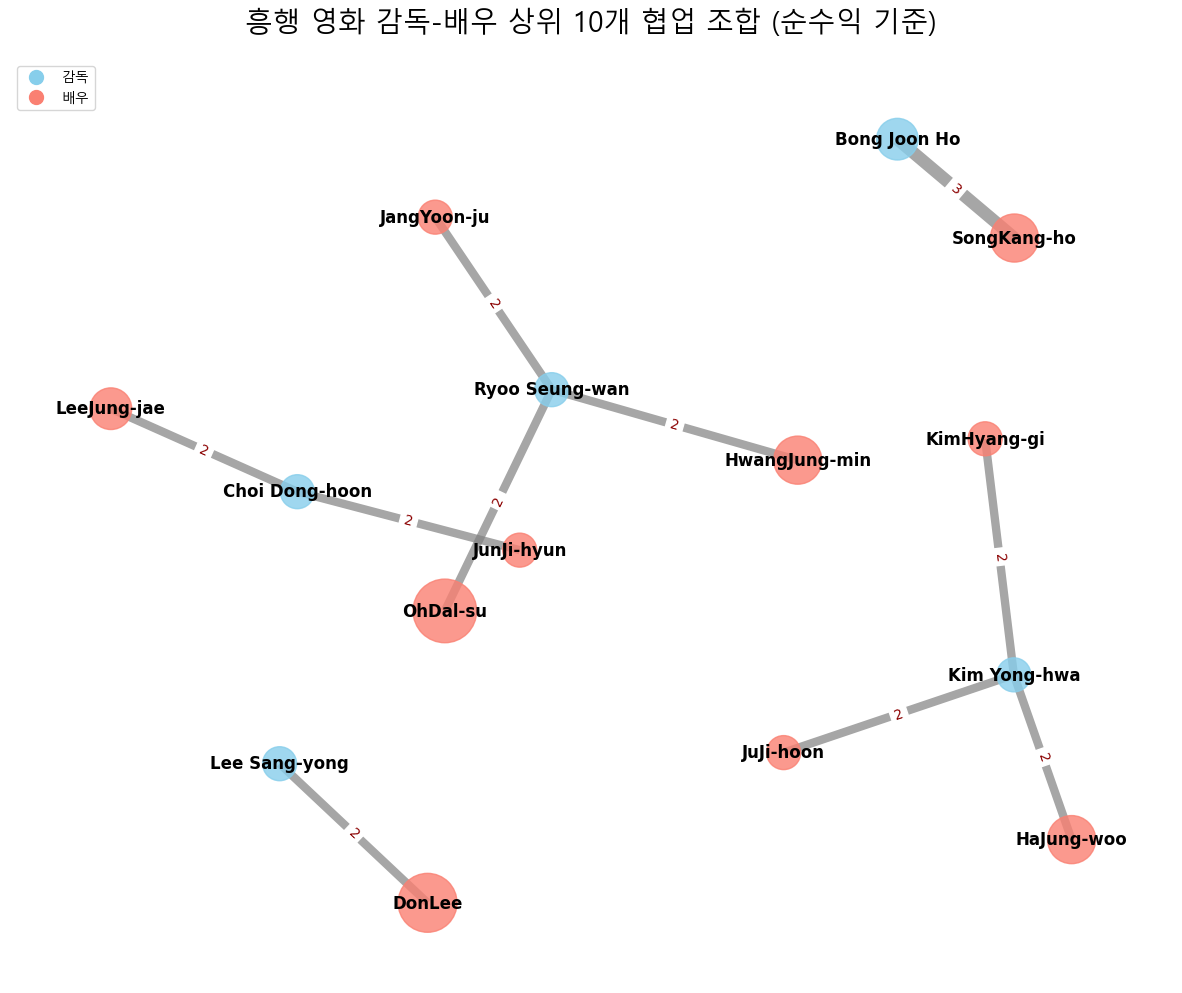


상위 10개 흥행 조합 네트워크 시각화가 완료되었습니다.
노드의 크기는 해당 인물이 흥행작에 참여한 총 횟수를 나타냅니다.
엣지(선)의 두께와 숫자는 해당 감독-배우 조합의 협업 횟수를 나타냅니다.


In [13]:
# 필요한 라이브러리들을 임포트합니다.
# 이 코드는 pandas, matplotlib, networkx 라이브러리가 이미 설치되어 있다고 가정합니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from collections import Counter
import re
import matplotlib.lines as mlines
import os

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore', category=UserWarning)

# 사용자가 요청한 폰트 및 설정 적용
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
print("Matplotlib 한글 폰트 설정이 완료되었습니다.")

# CSV 파일 경로를 여기에 입력하세요.
file_path = 'tmdb_with_credits.csv'

if not os.path.exists(file_path):
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    exit()

try:
    df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
    print("CSV 파일을 성공적으로 불러왔습니다.")
except Exception as e:
    print(f"데이터 로드 중 오류가 발생했습니다: {e}")
    exit()

# --- 배우 이름 문자열을 안전하게 파싱하는 함수 ---
def parse_actors(actor_string):
    """
    다양한 형식의 배우 이름 문자열을 파싱하여 리스트로 반환합니다.
    예: "['배우1', '배우2']", "배우1, 배우2"
    """
    if pd.isna(actor_string) or not actor_string:
        return []
    
    # 괄호와 따옴표를 제거합니다.
    clean_string = re.sub(r"[\[\]'\" ]", "", str(actor_string))
    
    # 쉼표를 기준으로 이름을 분리하고, 공백 제거 후 빈 문자열을 필터링합니다.
    actors_list = [name.strip() for name in clean_string.split(',') if name.strip()]
    return actors_list

df['actors'] = df['actors'].apply(parse_actors)
print("데이터프레임의 'actors' 열 변환이 완료되었습니다.")

# --- 흥행작 기준 정의 (순수익 상위 10%) ---
# 'revenue'와 'budget'을 사용하여 'profit' 컬럼을 새로 생성합니다.
df['profit'] = df['revenue'] - df['budget']
print("\n'profit' (순수익) 열이 생성되었습니다.")

# 유효한 순수익 데이터가 있는 행만 필터링합니다.
valid_profit_df = df[(df['profit'].notna()) & (df['profit'] > 0)].copy()

if valid_profit_df.empty:
    print("유효한 순수익 데이터가 있는 영화가 없습니다. 분석을 진행할 수 없습니다.")
    exit()

# 순수익 상위 10%를 기준으로 흥행작을 정의합니다.
profit_threshold = valid_profit_df['profit'].quantile(0.90)
hit_movies_df = valid_profit_df[valid_profit_df['profit'] >= profit_threshold].copy()
print(f"흥행작 순수익 기준 (상위 10%): ${profit_threshold:,.2f}")
print(f"총 {len(hit_movies_df)}개의 흥행작을 찾았습니다.")

if hit_movies_df.empty:
    print("90번째 백분위수 순수익을 기준으로 흥행작을 찾을 수 없습니다. 기준이 너무 높을 수 있습니다.")
    exit()

# --- 감독-배우 협업 횟수를 세어 상위 10개 조합 찾기 ---
collaboration_counts = Counter()
for _, row in hit_movies_df.iterrows():
    director = row['director']
    actors_list = row['actors']
    
    if pd.isna(director):
        continue

    for actor in actors_list:
        if not actor:
            continue
        collaboration_counts[(director, actor)] += 1

# 상위 10개 조합 추출
top_10_collaborations = collaboration_counts.most_common(10)
print(f"\n상위 10개 협업 조합:")
for (director, actor), count in top_10_collaborations:
    print(f"  - {director} & {actor}: {count}회 협업")

if not top_10_collaborations:
    print("협업 조합을 찾을 수 없습니다. 프로그램을 종료합니다.")
    exit()

# --- 상위 10개 협업만을 위한 네트워크 그래프 생성 ---
G_top = nx.Graph()

# 상위 10개 조합에 속한 모든 인물을 수집
personnel_in_top_10 = set()
for (director, actor), _ in top_10_collaborations:
    personnel_in_top_10.add(director)
    personnel_in_top_10.add(actor)

# 노드와 엣지 생성
for (director, actor), count in top_10_collaborations:
    # 감독 노드와 배우 노드 추가
    G_top.add_node(director, type='director')
    G_top.add_node(actor, type='actor')
    
    # 엣지 추가 (가중치는 협업 횟수)
    G_top.add_edge(director, actor, weight=count)

# 상위 10개 인물의 흥행작 참여 횟수 카운트
personnel_participation_counts = Counter()
for person in personnel_in_top_10:
    for _, row in hit_movies_df.iterrows():
        director = row['director']
        actors_list = row['actors']
        if pd.notna(director) and director == person:
            personnel_participation_counts[person] += 1
        elif person in actors_list:
            personnel_participation_counts[person] += 1

# 노드 크기를 흥행작 참여 횟수에 비례하여 설정
node_sizes = [personnel_participation_counts.get(node, 0) * 300 for node in G_top.nodes()]

# 노드 색상을 감독/배우에 따라 설정
node_colors = ['skyblue' if G_top.nodes[n]['type'] == 'director' else 'salmon' for n in G_top.nodes()]

# 엣지 두께를 협업 횟수에 비례하여 설정
edge_weights = [G_top[u][v]['weight'] for u, v in G_top.edges()]
edge_widths = [weight * 3 for weight in edge_weights]

# 그래프 레이아웃 설정
pos = nx.spring_layout(G_top, k=1.0, iterations=50, seed=42)

plt.figure(figsize=(15, 12))
plt.title("흥행 영화 감독-배우 상위 10개 협업 조합 (순수익 기준)", fontsize=20, pad=20)

# 노드, 엣지, 라벨 그리기
nx.draw_networkx_nodes(G_top, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G_top, pos, width=edge_widths, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(G_top, pos, font_size=12, font_color='black', font_weight='bold')

# 엣지 라벨(협업 횟수) 추가
edge_labels = nx.get_edge_attributes(G_top, 'weight')
nx.draw_networkx_edge_labels(G_top, pos, edge_labels=edge_labels, font_size=10, font_color='darkred')

# 범례 추가
legend_elements = [
    mlines.Line2D([], [], color='skyblue', marker='o', linestyle='None',
                  markersize=10, label='감독'),
    mlines.Line2D([], [], color='salmon', marker='o', linestyle='None',
                  markersize=10, label='배우')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.axis('off')
plt.show()

print("\n상위 10개 흥행 조합 네트워크 시각화가 완료되었습니다.")
print("노드의 크기는 해당 인물이 흥행작에 참여한 총 횟수를 나타냅니다.")
print("엣지(선)의 두께와 숫자는 해당 감독-배우 조합의 협업 횟수를 나타냅니다.")


#### **시너지를 창출하는 배우-감독 협업 사례 분석**

제공된 과제 3의 네트워크 분석 결과는 단순히 흥행에 성공한 조합을 보여주는 것을 넘어, 특정 감독과 배우가 어떻게 창의적인 시너지를 발휘하여 성공을 이끌어냈는지에 대한 중요한 단서를 제공합니다. 다음은 데이터를 통해 확인할 수 있는 대표적인 성공 협업 사례와 그 시너지에 대한 분석입니다.

1. 봉준호 감독과 송강호 배우
네트워크 분석에서 가장 강력한 협업 관계로 나타나는 조합 중 하나입니다. 두 사람은 '살인의 추억', '괴물', '설국열차', '기생충' 등 여러 작품에서 협업하며 매번 놀라운 흥행과 작품성을 동시에 거머쥐었습니다.

시너지 분석:

장르의 경계를 허무는 조합: 봉준호 감독은 사회적 메시지를 스릴러, 코미디, 드라마 등 다양한 장르에 절묘하게 녹여내는 연출의 귀재입니다. 송강호 배우는 이러한 복합적인 캐릭터를 완벽하게 소화해내는 뛰어난 연기력을 가졌습니다. 그의 능청스러운 생활 연기는 '괴물'의 평범한 아버지, '기생충'의 가난한 가장 등 봉 감독이 그려내는 입체적인 캐릭터에 생명력을 불어넣습니다.

상호 간의 신뢰: 여러 작품을 함께하며 쌓인 깊은 신뢰는 두 사람이 서로의 창의성을 한계 없이 펼칠 수 있게 합니다. 봉 감독의 독특한 비전은 송 배우의 폭넓은 연기 스펙트럼과 만나 매번 새로운 결과물을 창출해냈습니다.

2. 박찬욱 감독과 최민식 배우
'올드보이'와 '친절한 금자씨'를 통해 충격적이고 스타일리시한 '복수 3부작'의 정점을 찍은 조합입니다. 이들의 협업은 독창적인 미장센과 강렬한 서사를 결합한 한국 영화의 새로운 지평을 열었습니다.

시너지 분석:

압도적인 에너지의 결합: 박찬욱 감독의 정교하고 미학적인 연출은 최민식 배우의 폭발적이고 몰입도 높은 연기와 만나 시너지를 극대화합니다. '올드보이'에서 최민식 배우가 보여준 광기와 고뇌는 박 감독의 미장센과 결합하여 관객에게 잊을 수 없는 경험을 선사했습니다.

감정의 깊이를 탐구하는 파트너십: 두 사람은 인간 내면의 어두운 감정을 깊이 있게 탐구하는 공통점을 가졌습니다. 이들의 협업은 단순히 오락적인 요소를 넘어, 심오하고 철학적인 메시지를 강렬하게 전달하는 힘을 가졌습니다.

3. 윤종빈 감독과 하정우 배우
'용서받지 못한 자', '범죄와의 전쟁', '군도' 등 굵직한 작품에서 함께한 조합입니다. 이들은 특히 남성적이고 거친 서사를 스타일리시하게 풀어내는 데 강점을 보였습니다.

시너지 분석:

현실적인 캐릭터 구축: 윤종빈 감독의 섬세한 연출력은 하정우 배우의 뛰어난 캐릭터 해석 능력과 만나 시너지를 발휘합니다. 특히 '범죄와의 전쟁'에서 보여준 하정우 배우의 연기는 윤 감독이 그려내고자 했던 1980년대 부산의 시대적 분위기와 인물의 욕망을 완벽하게 표현했습니다.

신뢰를 기반으로 한 완성도: 학생 때부터 함께 작업해 온 오랜 파트너십은 서로의 작업 방식을 잘 이해하고 있기에 가능한 결과입니다. 이는 복잡한 캐릭터의 심리를 깊이 있게 파고들고, 서사의 완성도를 높이는 데 크게 기여했습니다.

4. 류승완 감독과 황정민 배우
'부당거래', '베테랑', '군함도' 등에서 긴밀한 협업을 이어온 조합입니다. 이들의 작품은 사회의 부조리를 통쾌하게 비판하면서도, 대중성을 놓치지 않는 강점을 보였습니다.

시너지 분석:

폭발적인 에너지와 현실성의 결합: 류승완 감독의 속도감 있는 액션 연출과 황정민 배우의 거침없고 현실적인 연기가 만나 강력한 시너지를 냅니다. 황정민 배우는 정의로운 형사부터 비열한 검사까지 폭넓은 캐릭터를 완벽하게 소화하며 감독의 비전을 현실로 구현합니다.

흥행과 메시지 두 마리 토끼: 두 사람은 오락적인 재미 속에 씁쓸한 사회 비판을 담아 관객의 공감을 이끌어내는 데 탁월한 능력을 보였습니다.

5. 최동훈 감독과 김윤석 배우
'타짜', '전우치', '도둑들', '암살' 등 수많은 흥행작을 함께 만들어낸 조합입니다. 최동훈 감독의 치밀한 범죄 오락 영화에 김윤석 배우의 개성 넘치는 캐릭터 연기가 더해져 큰 성공을 거두었습니다.

시너지 분석:

개성 넘치는 앙상블의 중심: 최동훈 감독의 작품은 다수의 매력적인 캐릭터들이 얽히고설키는 앙상블이 중요한데, 김윤석 배우는 그 중심에서 존재감을 확실히 드러내며 극을 이끌어갑니다.

깊이 있는 캐릭터 해석: 김윤석 배우는 단순히 표면적인 역할에 그치지 않고, 인물의 복잡한 내면과 욕망을 깊이 있게 표현해 영화의 완성도를 높였습니다. 이는 관객들이 캐릭터에 더욱 몰입하게 만드는 원동력이 됩니다.